In [161]:
import pandas as pd
import numpy as np
import struct
from scipy.stats import uniform
from statsmodels.api import qqplot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from adjustText import adjust_text
import warnings
warnings.filterwarnings('ignore')

In [162]:
df = pd.read_excel("Тестовое задание.xlsx")

In [163]:
df

,area,cluster,cluster_name,keyword,good (1),count,x,y
0,eligibility,0.0,Кластер 0,several animated buried,1.0,1260,5.772342,12.564796257345005
1,eligibility,0.0,Кластер 0,singles unusual buyers,1.0,866,14.829280,7.8507285727125815
2,eligibility,0.0,Кластер 0,hawaiian directive,1.0,163,11.381856,3.8981370219558604
3,eligibility,0.0,Кластер 0,dynamics directly,1.0,1146,9.980149,6.281427914064545
4,eligibility,1.0,Кластер 1,decision surgeons montreal,1.0,823,3.283940,4.39674063521296
...,...,...,...,...,...,...,...,...
224,greetings,2.0,Кластер 2,disposition layout,1.0,279,10.971214,4.857810387061303
225,greetings,2.0,Кластер 2,sapphire grounds,1.0,335,1.160626,3.642819729434763
226,greetings,3.0,Кластер 3,entire ethical speakers,1.0,1782,7.985910,6.003699268483375
227,greetings,3.0,Кластер 3,courtesy textiles diameter,1.0,84,0.509490,4.151198803764073


In [164]:
df.drop(["good (1)"], axis = 1, inplace  = True)

# EDA

<h2>Обработка пропущенных значений</h2>

In [165]:
df.isna().sum()

area            1
cluster         1
cluster_name    1
keyword         1
count           2
x               1
y               1
dtype: int64

<h5>У нас в данных есть полность пропущенный объект, избавимся от него:</h5>

In [166]:
df.dropna(how = 'all', inplace = True)

<h5>У 99 объекта координата y имеет не десятичное представление, переведём его:*Курсив*</h5>

In [167]:
df.y[99] = struct.unpack('!f', bytes.fromhex('414fe002'))[0]

In [168]:
df['y'] = pd.to_numeric(df['y'])

<h5>В колонке count есть пропущенное значение, восстановим его, для начала переведя к типу целочисленных</h5>

In [169]:
df['count'] = pd.to_numeric(df['count'],  errors='coerce')

<h5>Хотелось бы получить некоторую примерную статистическую оценку признаков, провизуализировать</h5>

<h5>Посмотрим на признаки координат:</h5>

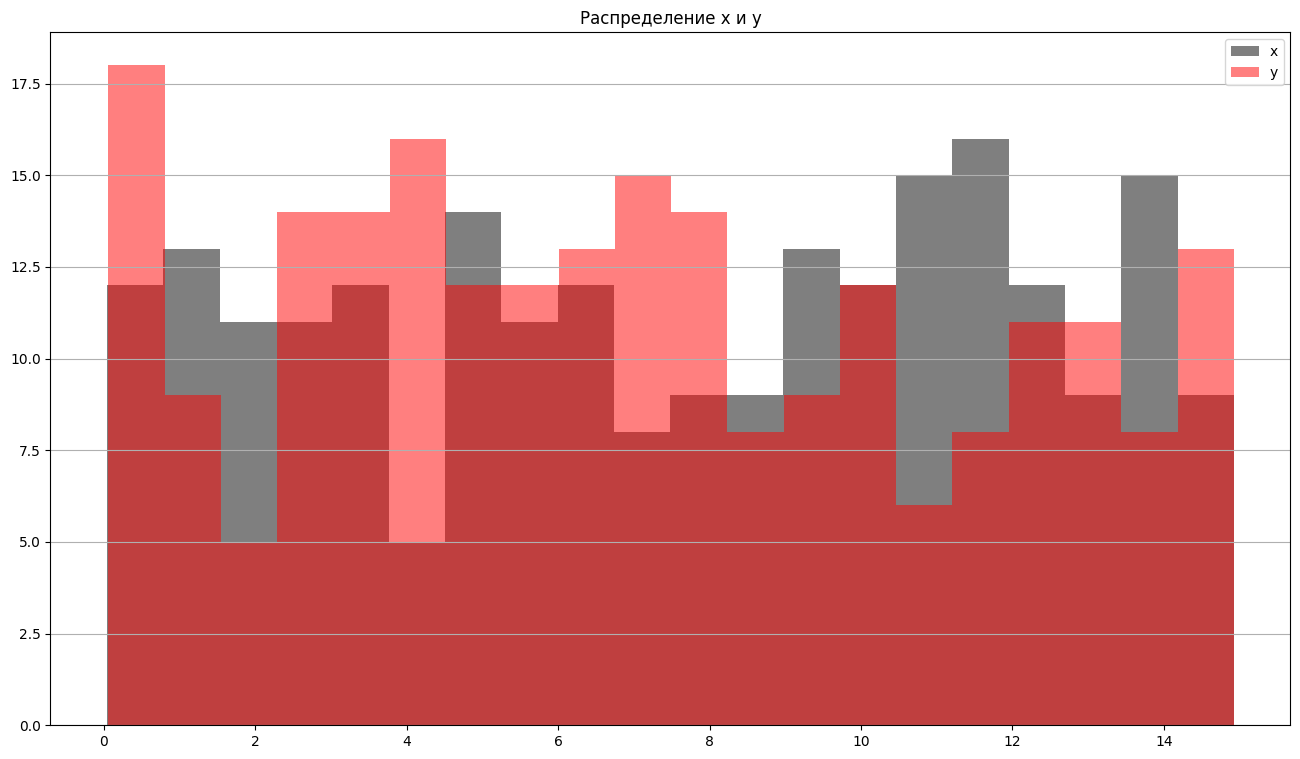

In [170]:
x = df['x']
y = df['y']
plt.figure(figsize = [16, 9])
plt.title('Распределение x и y')
plt.hist(x, alpha = 0.5, bins = 20, color = 'black')
plt.hist(y, alpha = 0.5, bins = 20, color = 'red')
plt.legend(['x' , 'y'])
plt.grid(axis = 'y')
plt.show()

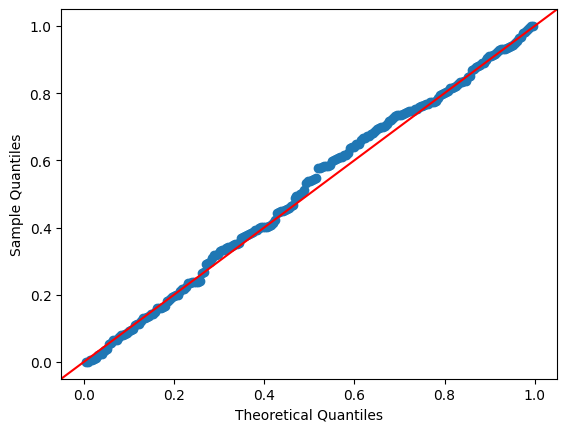

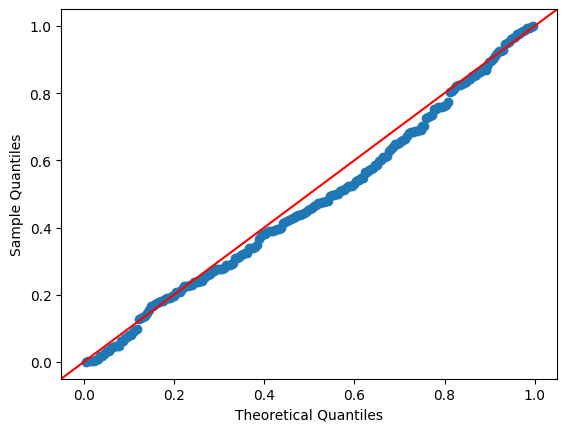

In [171]:
qqplot(df.x, uniform, line = '45', fit = True)
qqplot(df.y, uniform, line = '45', fit = True)
plt.show()

<h5>Распределние x, y - равномерное. Посмотрим на распределение count:</h5>

<h5>Возможно при оценки параметра count, играет роль область или кластер. Построем распредление учитывая области:</h5>

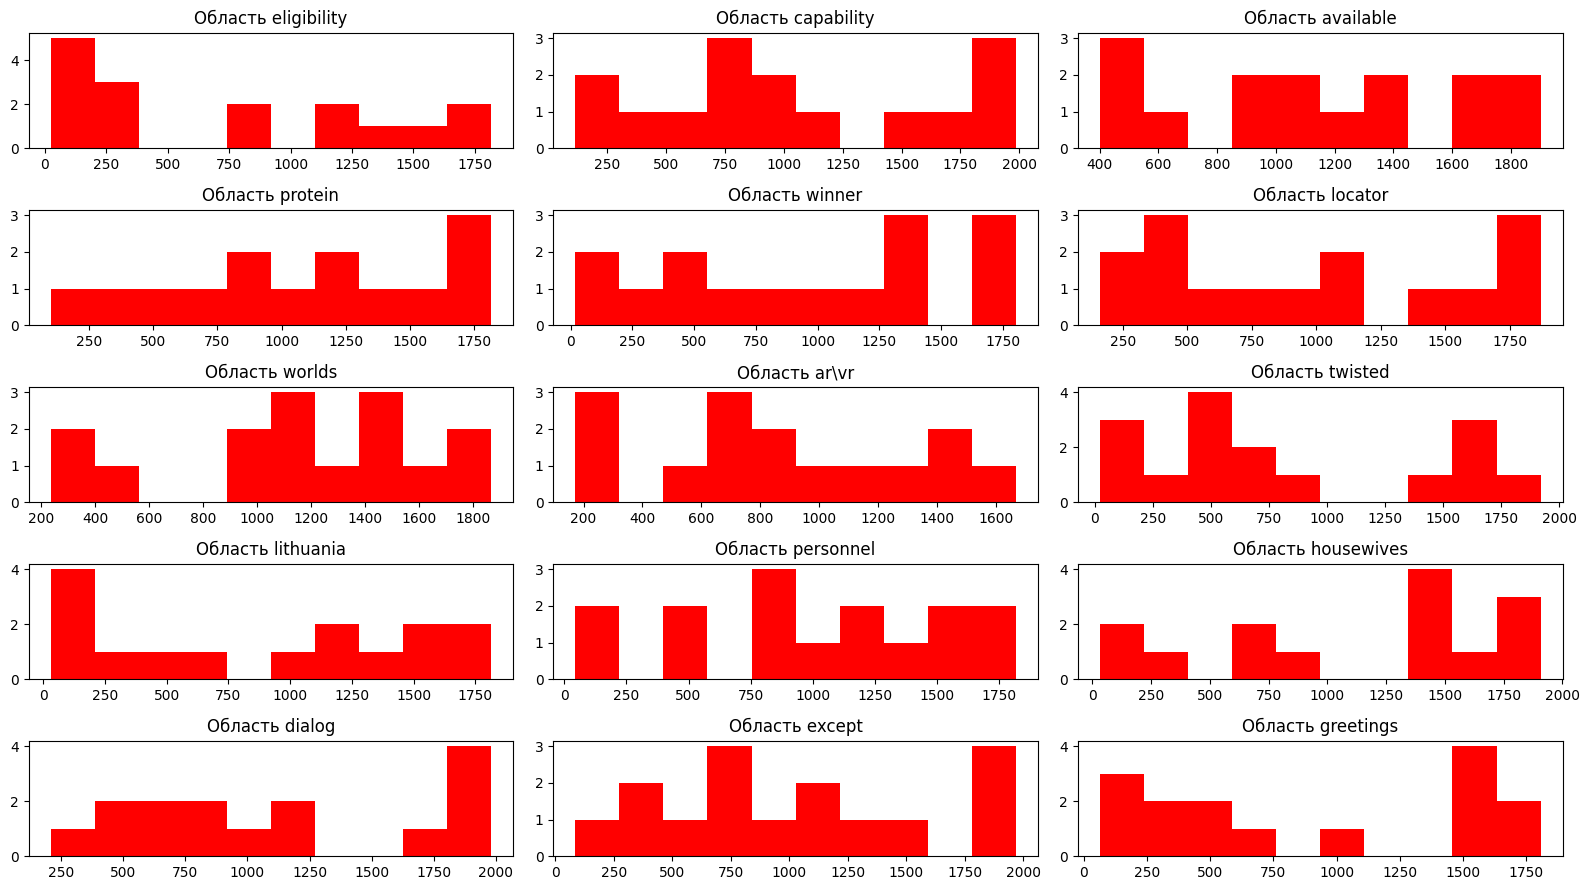

In [172]:
plt.figure(figsize = (16,9))
area_unique = df.area.unique() 
for i in range(len(area_unique)):
  subdata = df[df['area'] == area_unique[i]]
  plt.subplot(5, 3, i+1)
  plt.hist(subdata['count'], color = 'r')
  plt.title("Область " + area_unique[i])
plt.tight_layout()
plt.show()

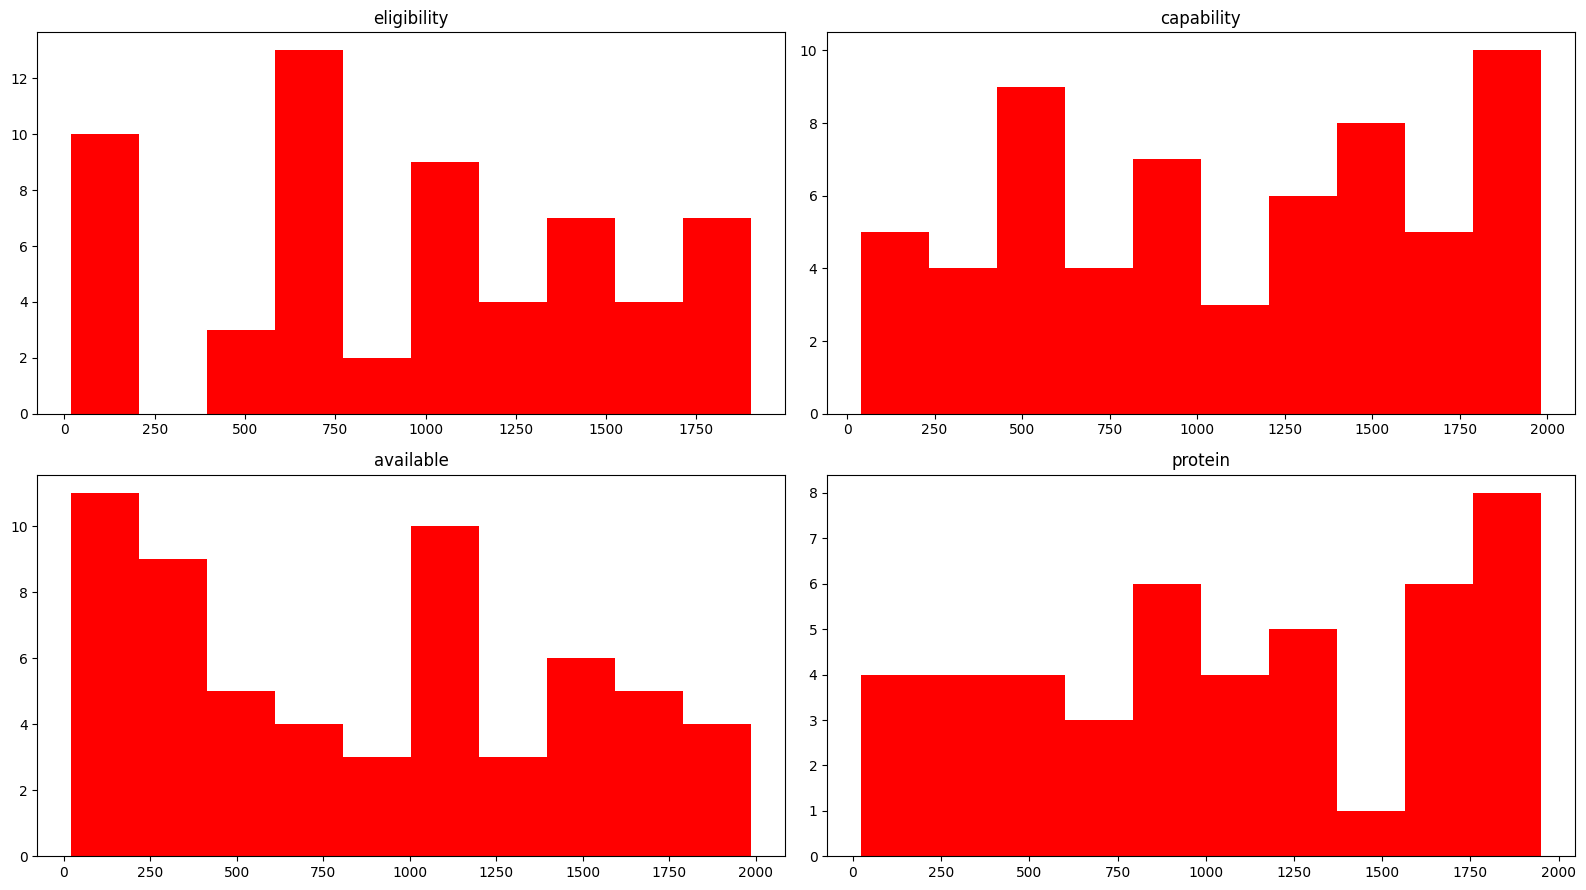

In [173]:
plt.figure(figsize = (16,9))
cluster_unique = df.cluster_name.unique() 
for i in range(len(cluster_unique)):
  subdata = df[df['cluster_name'] == cluster_unique[i]]
  plt.subplot(2, 2, i+1)
  plt.hist(subdata['count'], color = 'r')
  plt.title(area_unique[i])
plt.tight_layout()
plt.show()

(array([30., 18., 22., 23., 18., 28., 16., 22., 22., 26.]),
 array([  19. ,  215.7,  412.4,  609.1,  805.8, 1002.5, 1199.2, 1395.9,
        1592.6, 1789.3, 1986. ]),
 <BarContainer object of 10 artists>)

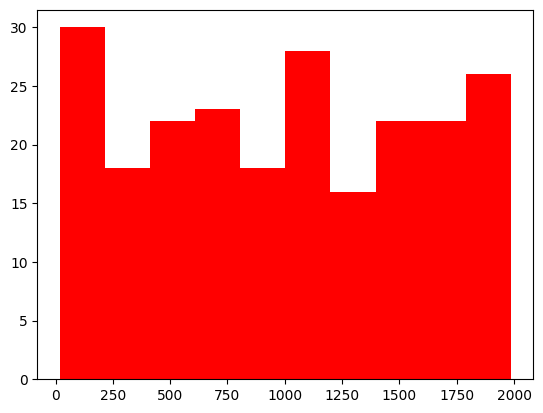

In [174]:
plt.hist(df['count'], color = 'r')

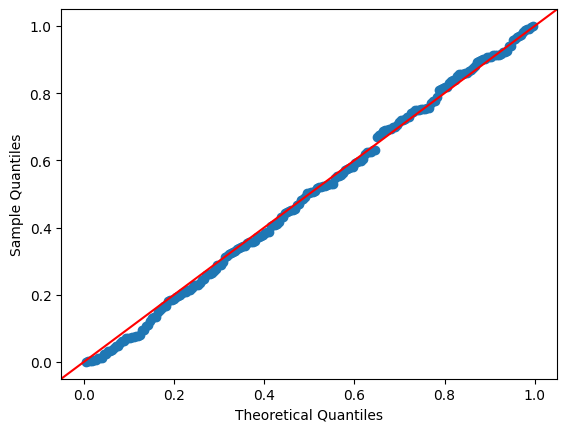

In [175]:
qqplot(df.iloc[np.where(df['count'].isna() == False)[0]]['count'], uniform, line = '45', fit = True)
plt.show()

<h5>Учитывая показатели qqplot хочется сказать, что count распределено равномерно, однако, учитывая гистограммы по группам надёжнее предположить, что  показатель зависит от области или кластера. По кластерам показатель отличается между собой не так сильно, как между областями (в общем говоря сложное распределение, где-то есть несколько выраженных мод, скорее лучше его апроксимировать смесью распределений, чем каким-либо одним). Вследствие, возможно лучше заполнить пропуски в count средним по соответствующим областям</h5>

In [176]:
df['count'] = df.groupby('cluster_name').transform(lambda x: x.fillna(x.mean()))['count']

<h5>Посмотрим наличие корреляции признаков</h5>

In [177]:
abs(df.corr()) < 8e-2

,cluster,count,x,y
cluster,False,True,True,True
count,True,False,True,True
x,True,True,False,True
y,True,True,True,False


<h5>Корреляция слабая у всех признаков попарно</h5>

# Часть 1. Работа с данными


<h5>В начале отсортируем данные согласно условиям:</h5>

In [178]:
data = df

In [179]:
data.sort_values(by = ['area', 'cluster', 'cluster_name'], inplace = True)
data.sort_values(by = 'count', inplace = True, ascending = False)

<h5>Добавим колонку color в соответствии с критериями: </h5>

In [180]:
colors = ['orange', 'red', 'blue', 'green']
def set_color(x):
  return colors[int(x[-1])]

In [181]:
data['color'] = data['cluster_name'].apply(set_color)

Предобработанный датасет и импортирование:

In [182]:
data

,area,cluster,cluster_name,keyword,count,x,y,color
26,capability,2.0,Кластер 2,transmitted australian,1986.0,5.655112,5.853698,blue
186,dialog,1.0,Кластер 1,interpretation connections,1981.0,4.409352,7.835285,red
209,except,2.0,Кластер 2,jacksonville tomatoes alberta,1968.0,6.760798,10.922626,blue
189,dialog,1.0,Кластер 1,coalition integration,1967.0,5.788947,14.868504,red
203,except,1.0,Кластер 1,announces independent latter senator,1960.0,2.260567,14.127058,red
...,...,...,...,...,...,...,...,...
151,lithuania,3.0,Кластер 3,indirect reminder,30.0,6.057519,8.093122,green
132,twisted,2.0,Кластер 2,turner navigate expenditures,23.0,11.253783,3.429091,blue
14,eligibility,3.0,Кластер 3,cowboy arthritis,23.0,3.598983,12.968220,green
133,twisted,2.0,Кластер 2,pieces appeals,22.0,3.024250,2.880182,blue


In [183]:
data.to_excel("data_processed.xlsx", index = False)

# Часть 2. Построение графиков

Визуализация и импортировние

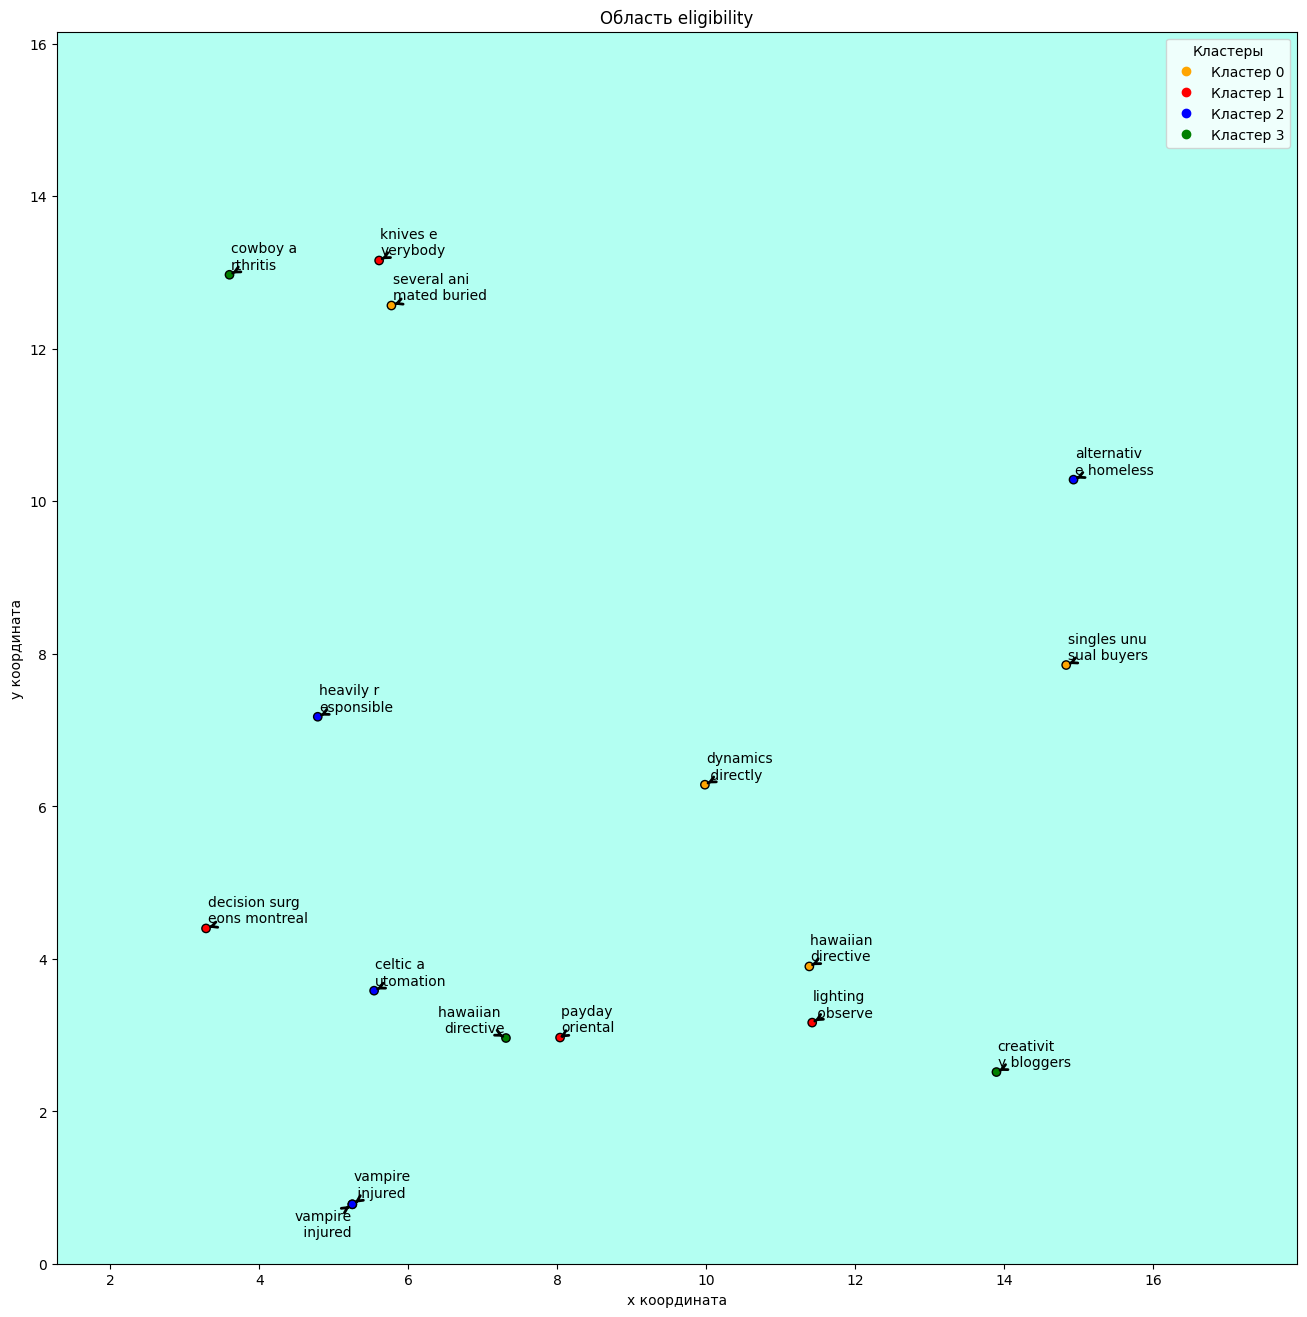

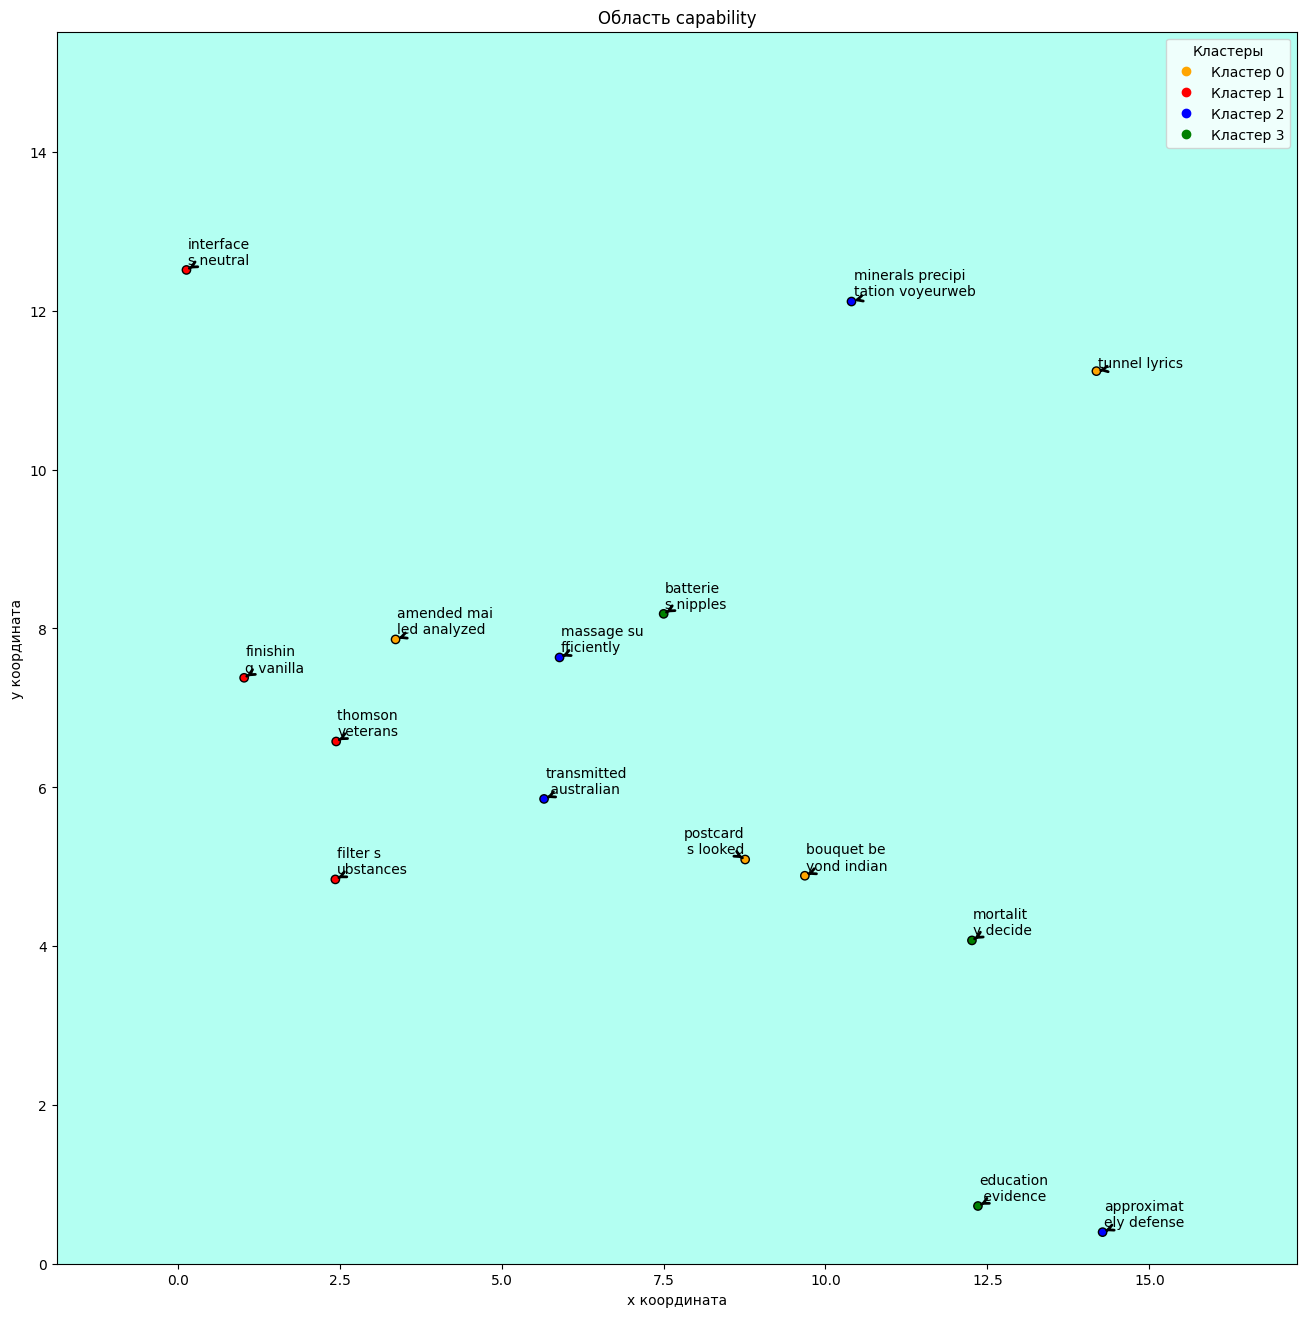

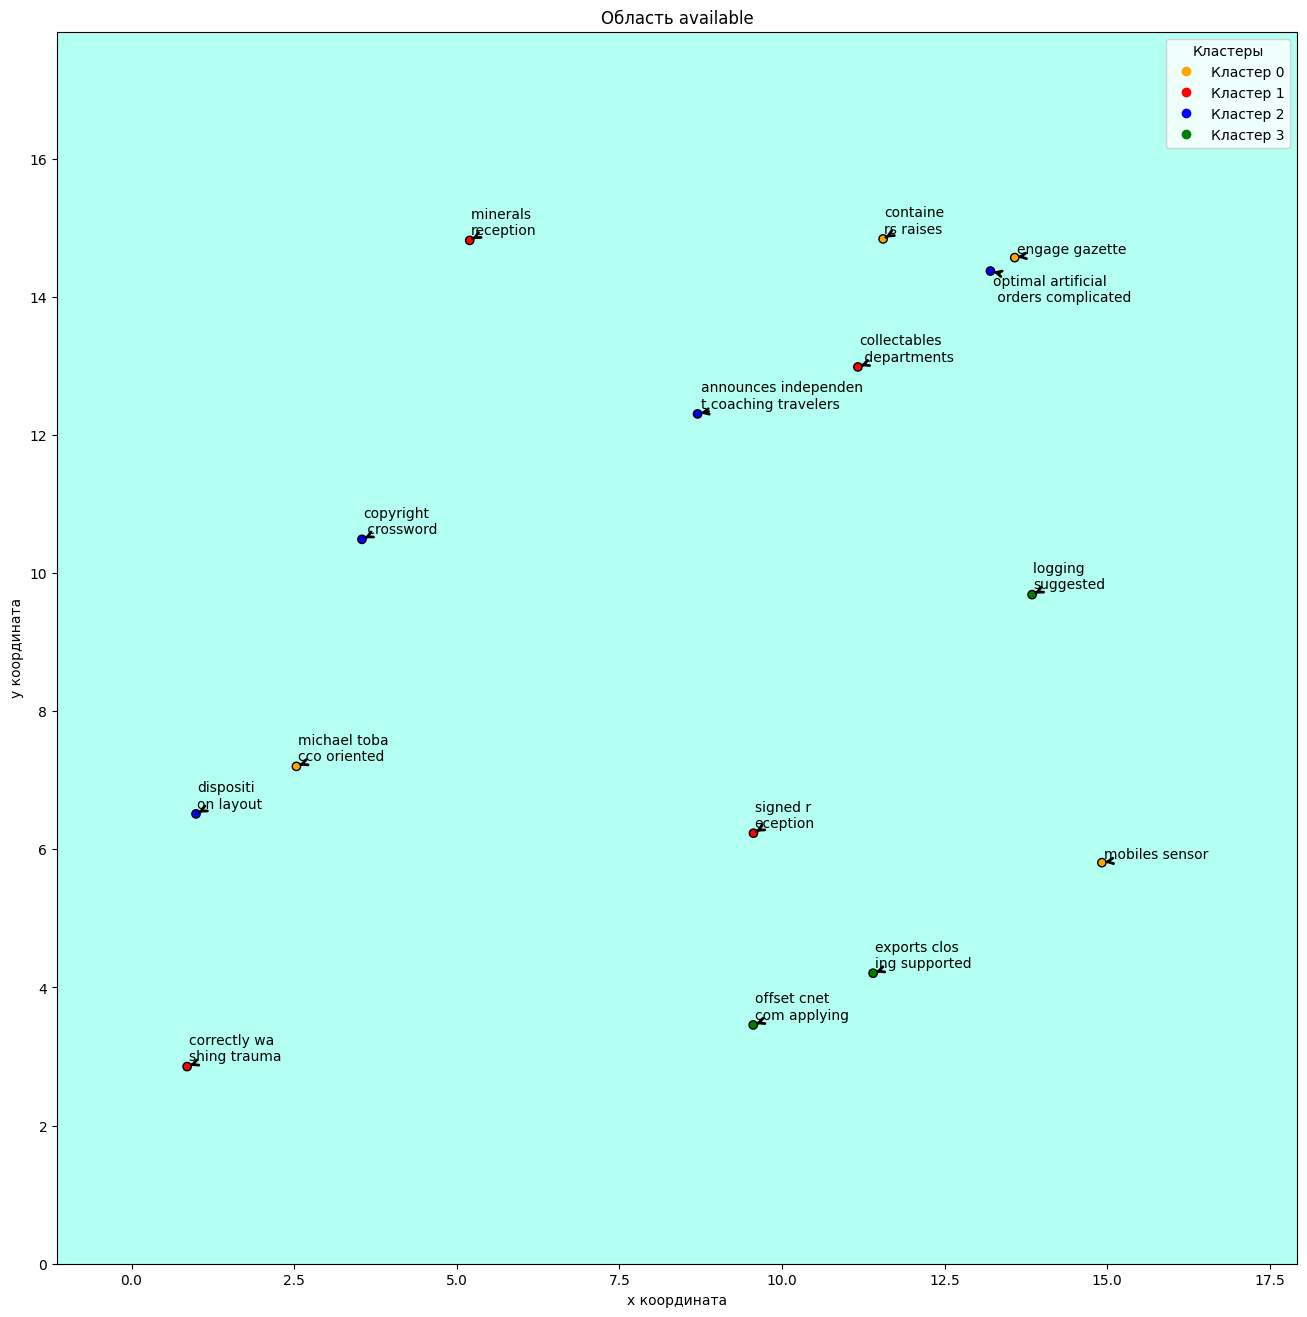

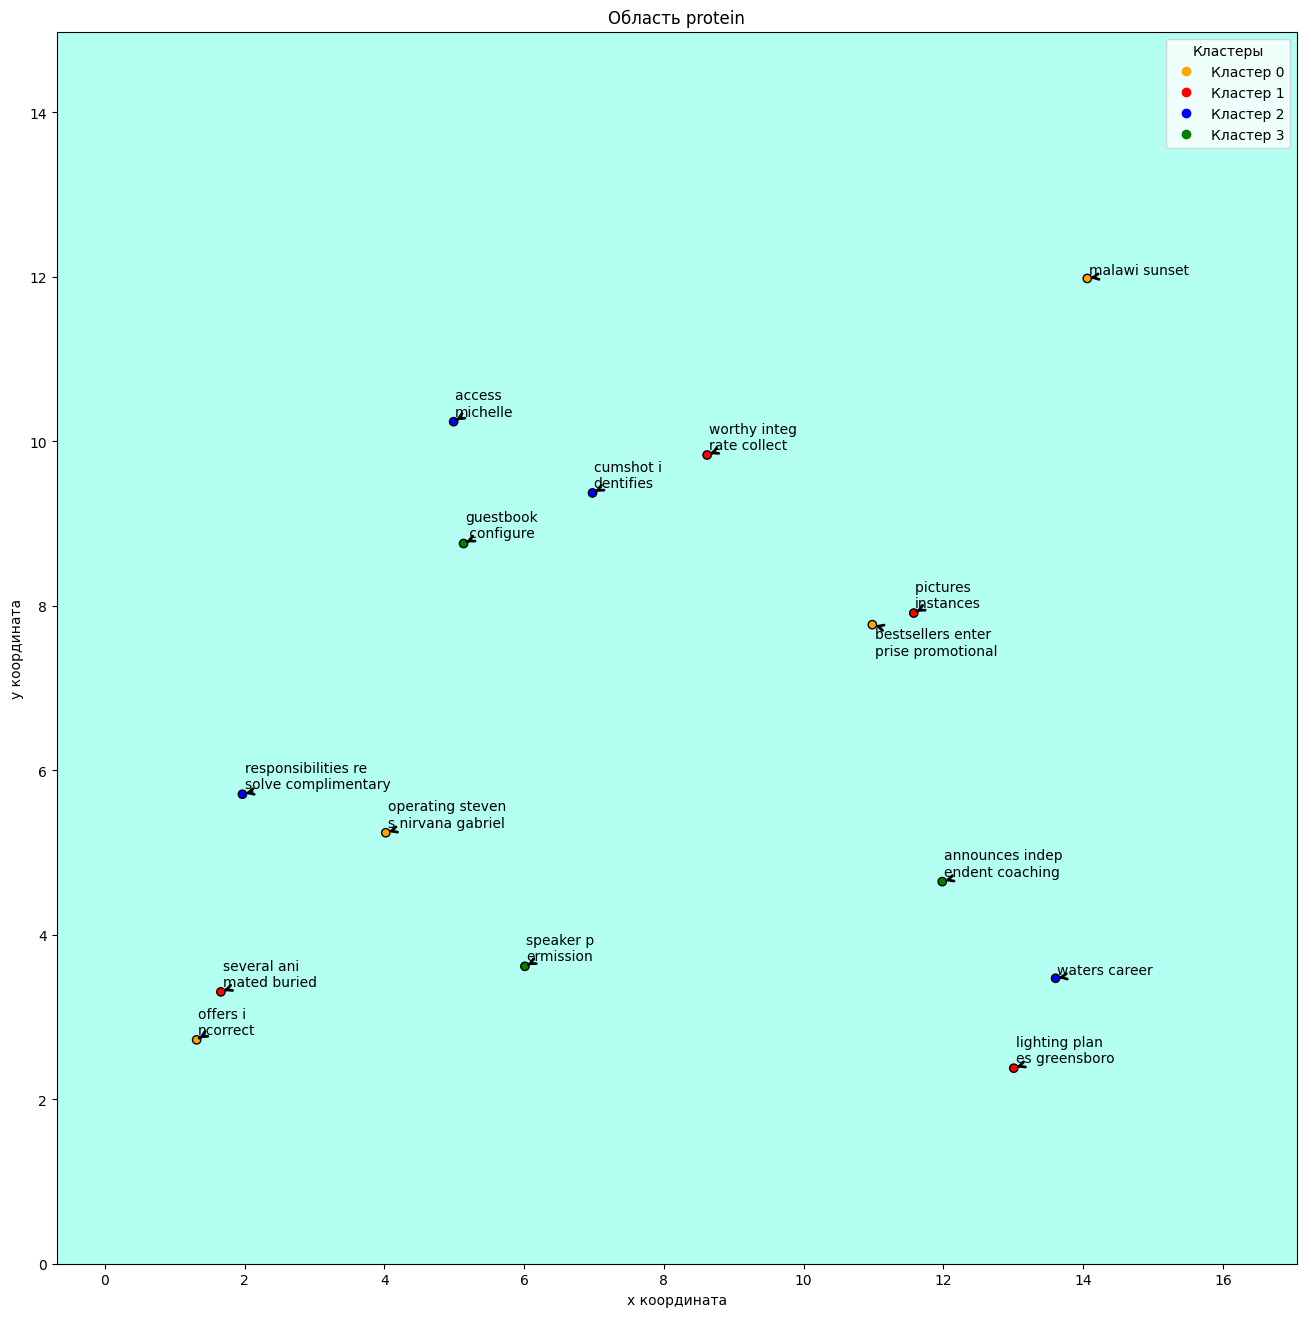

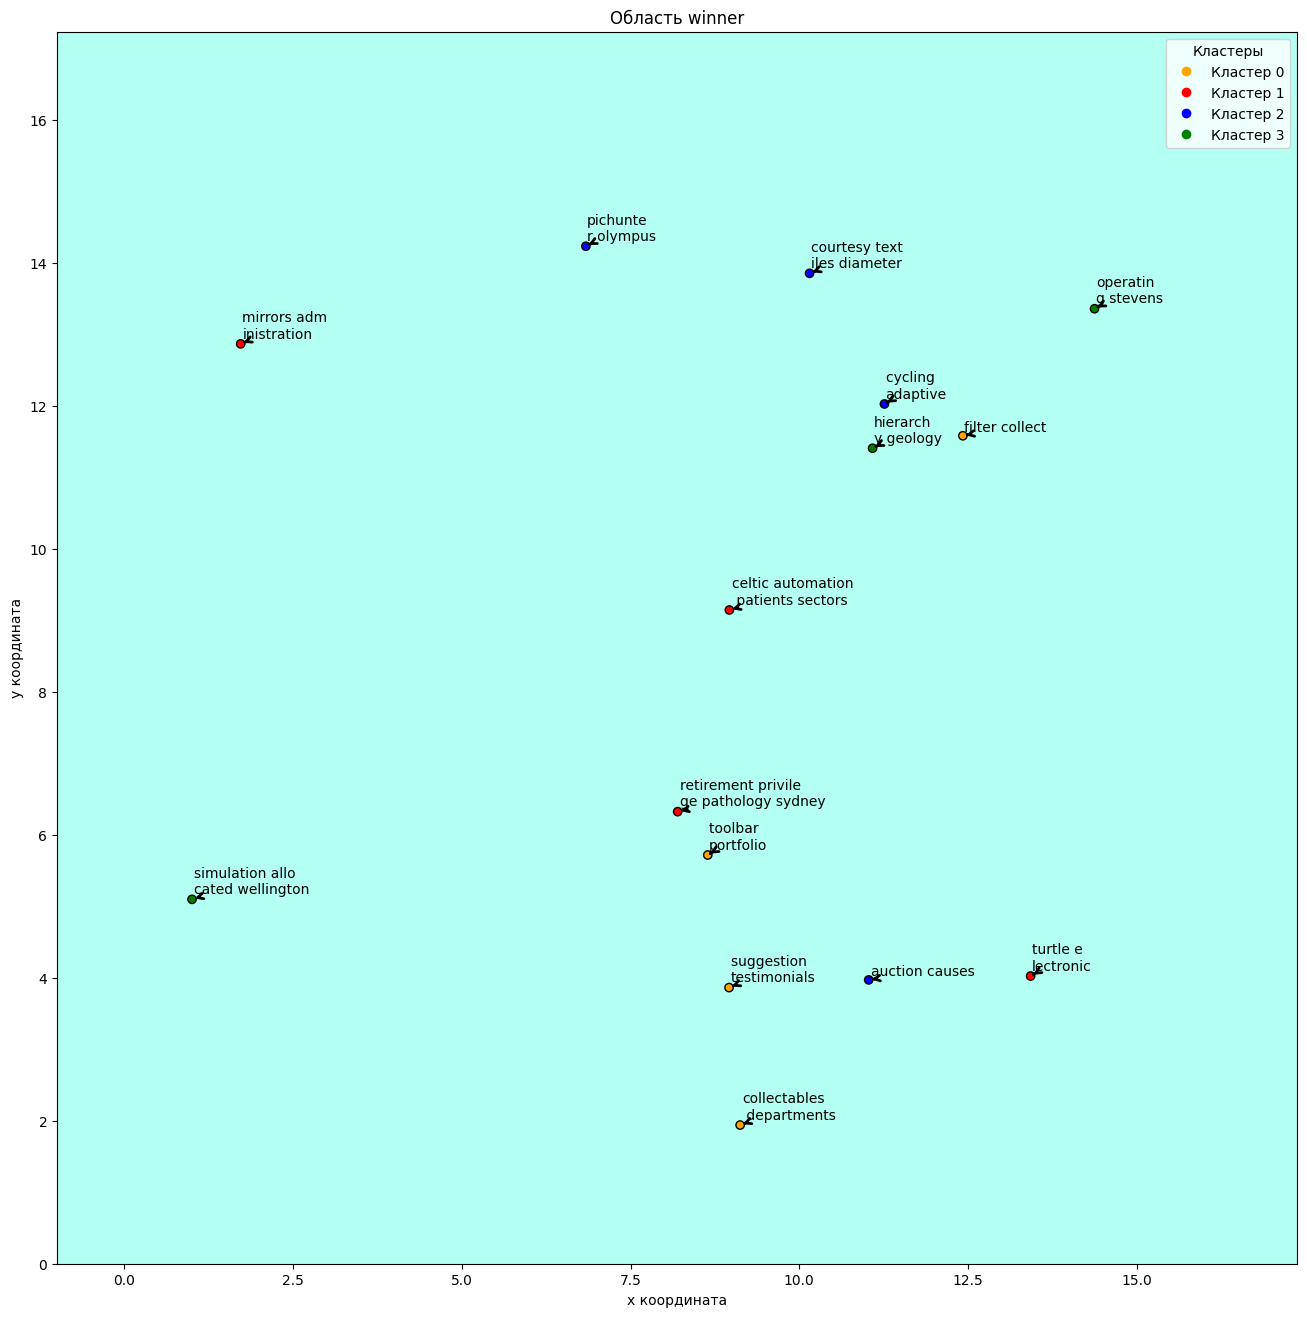

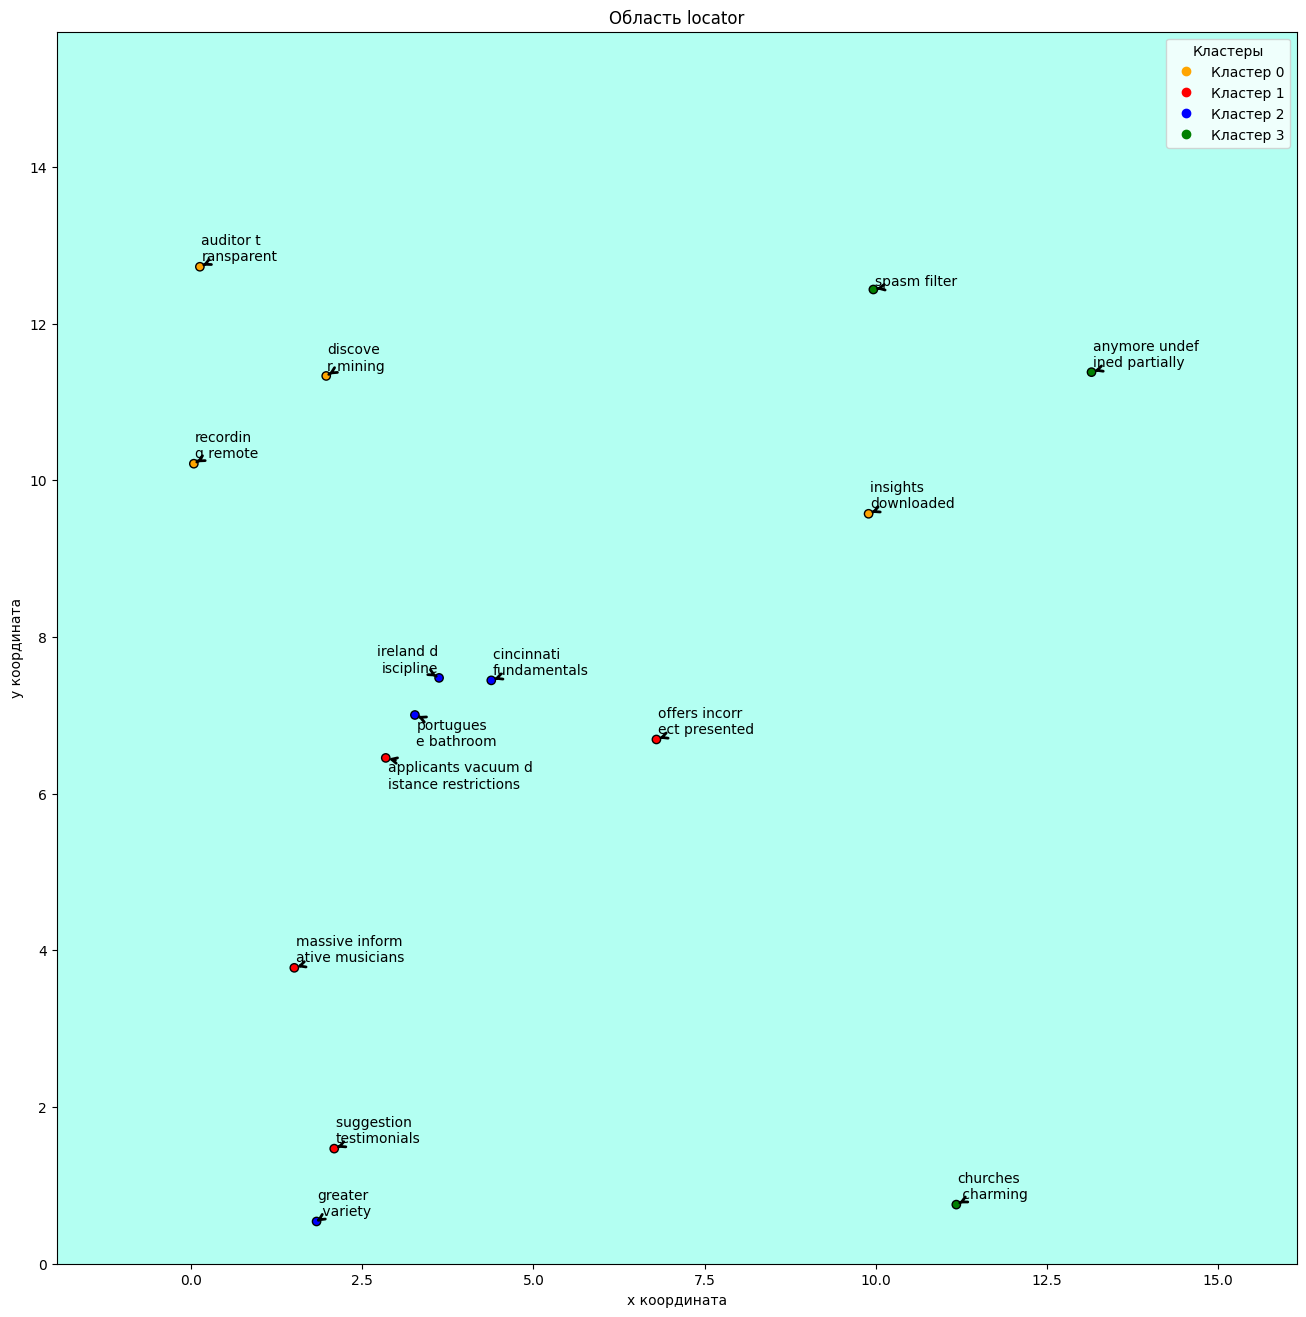

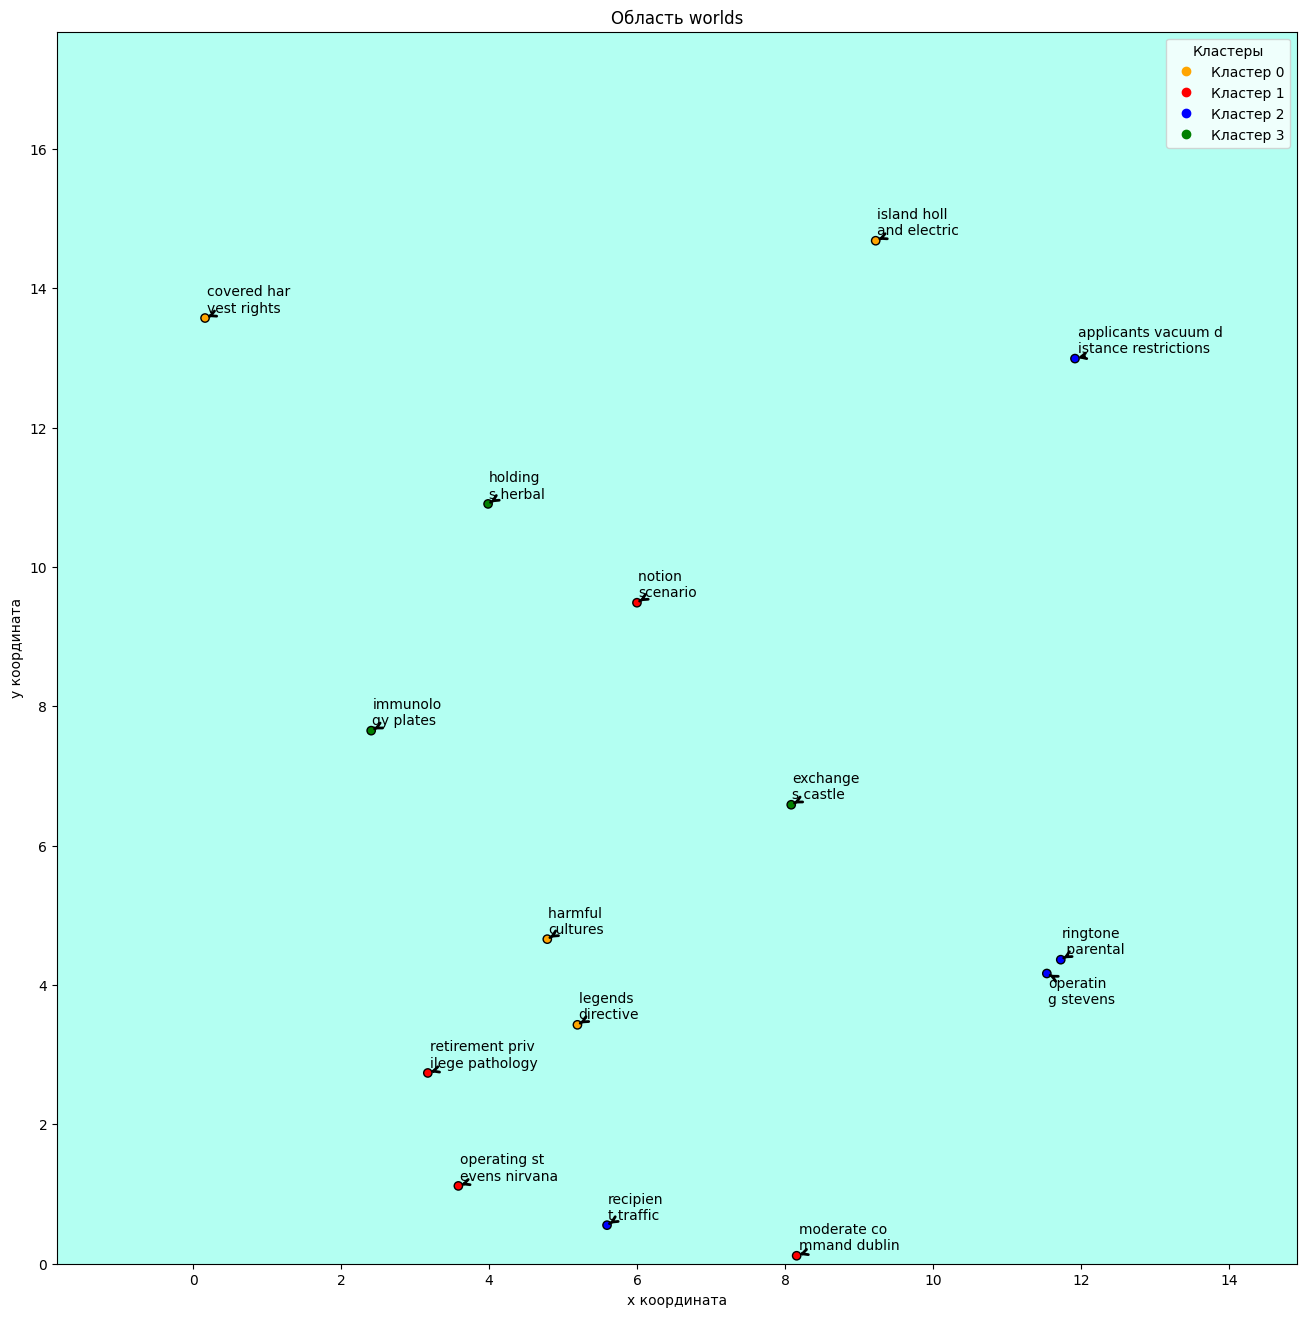

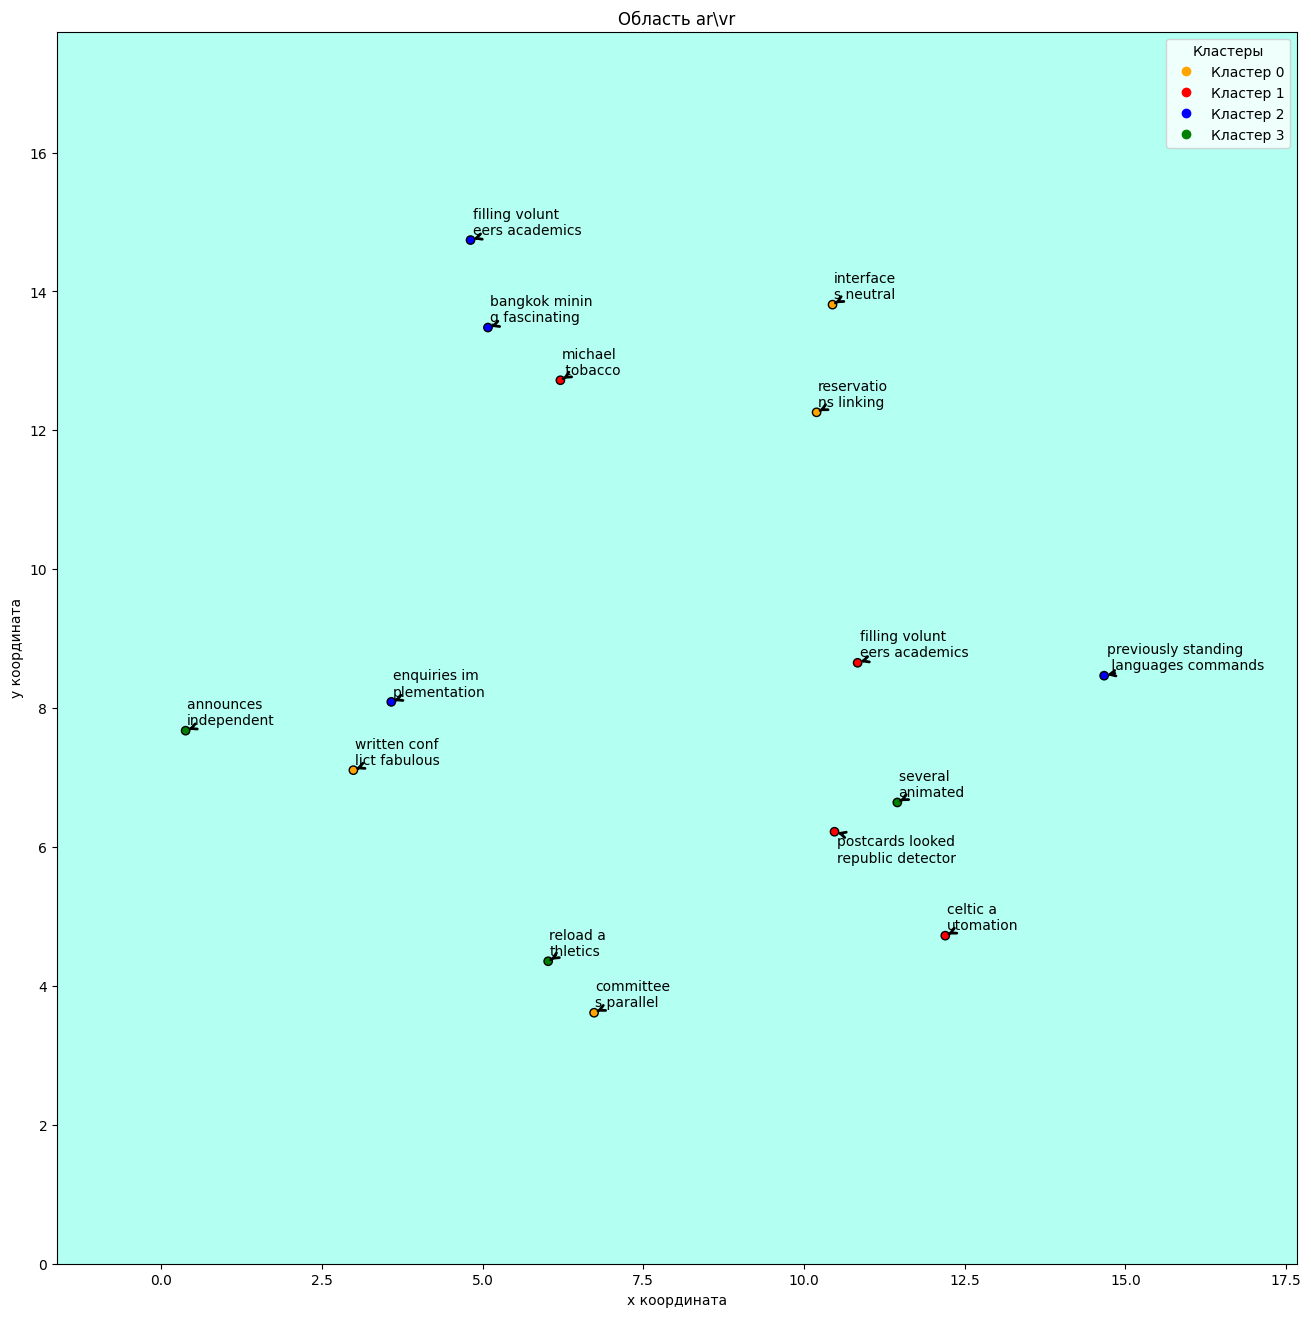

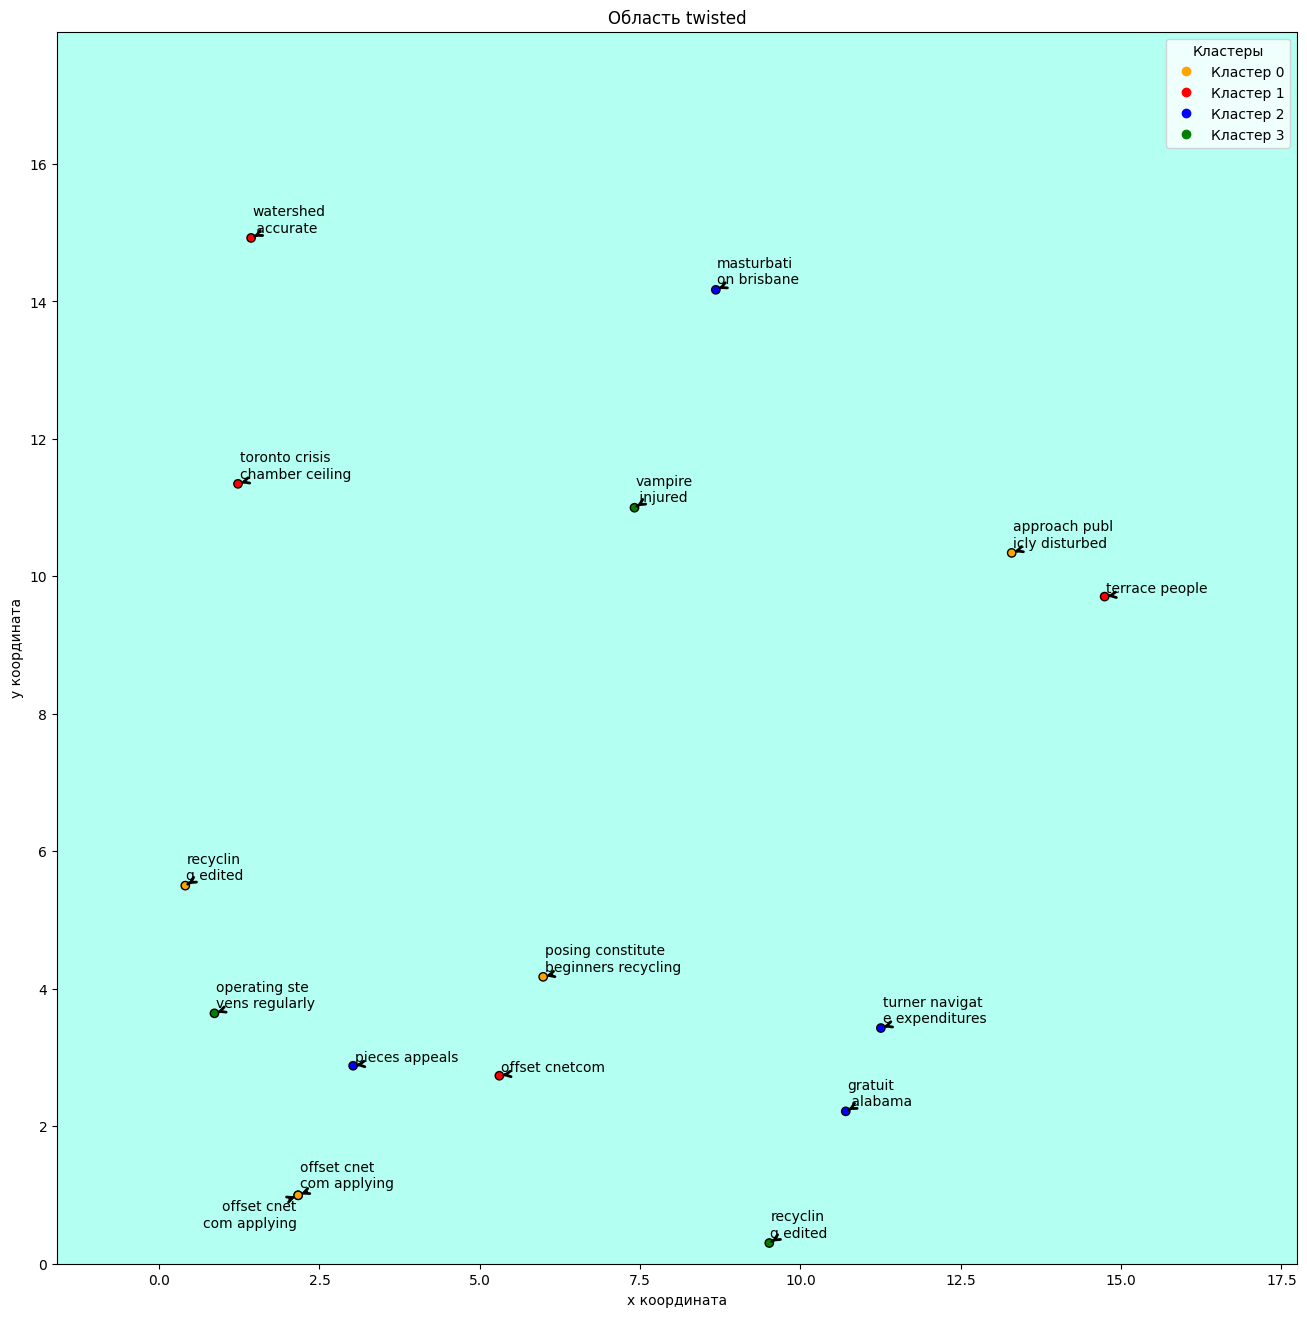

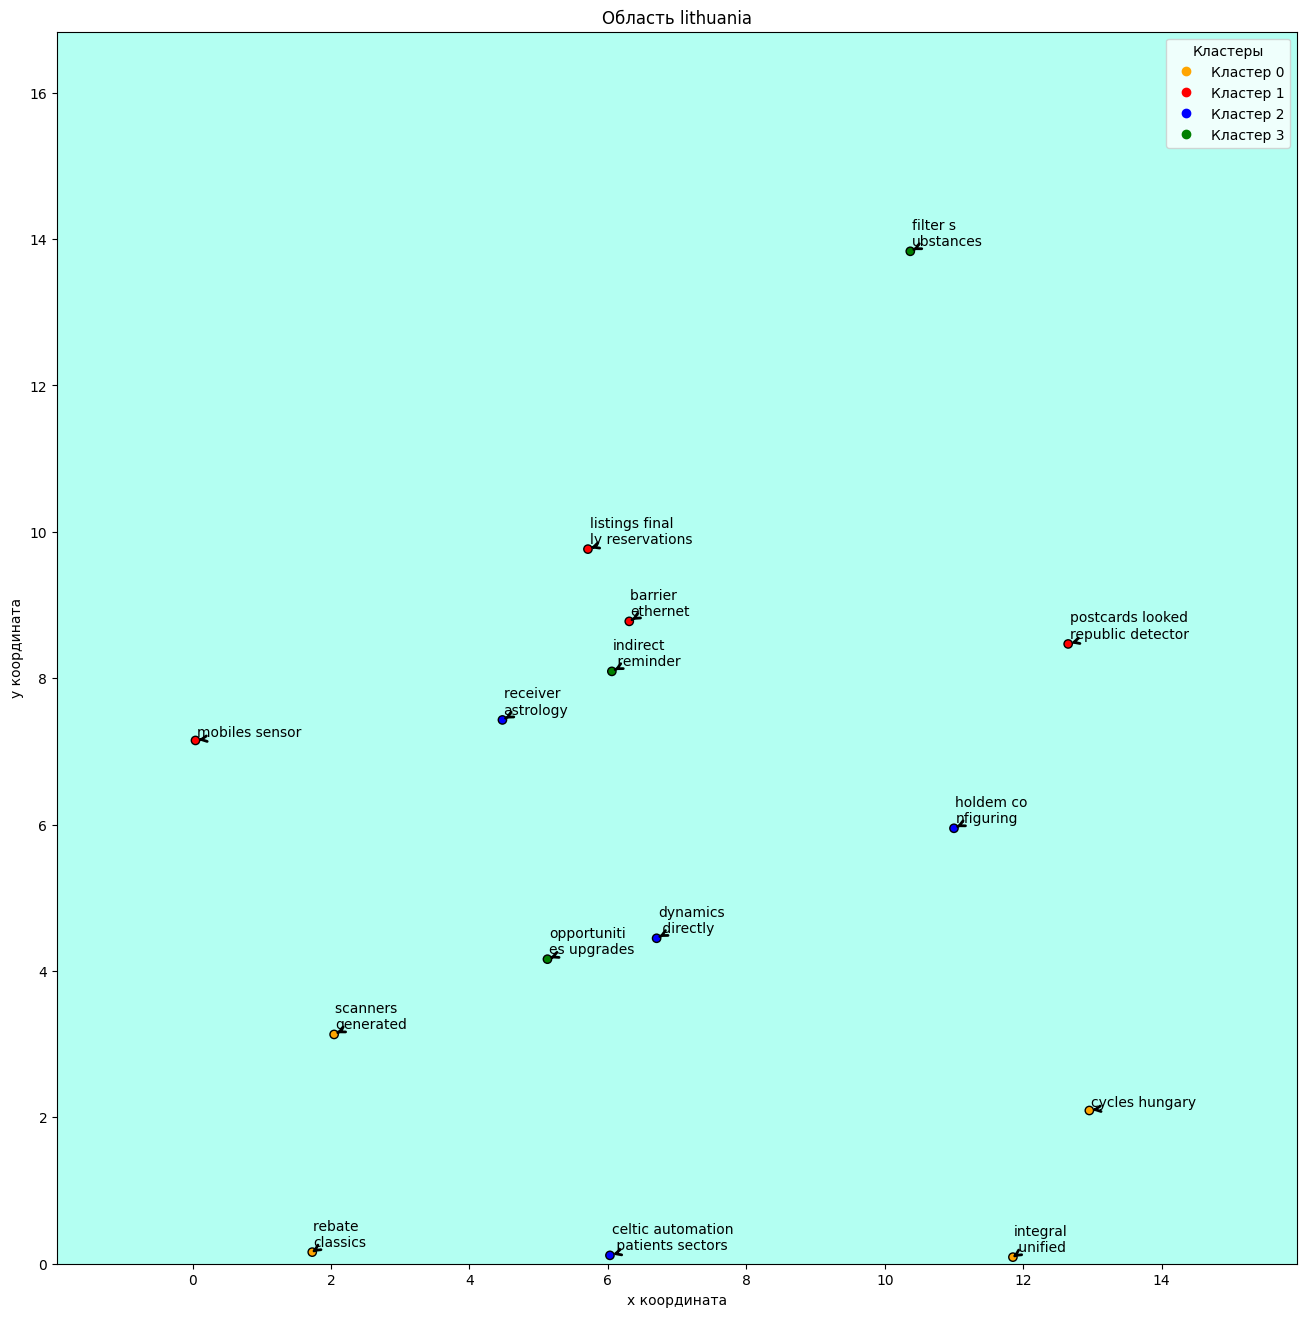

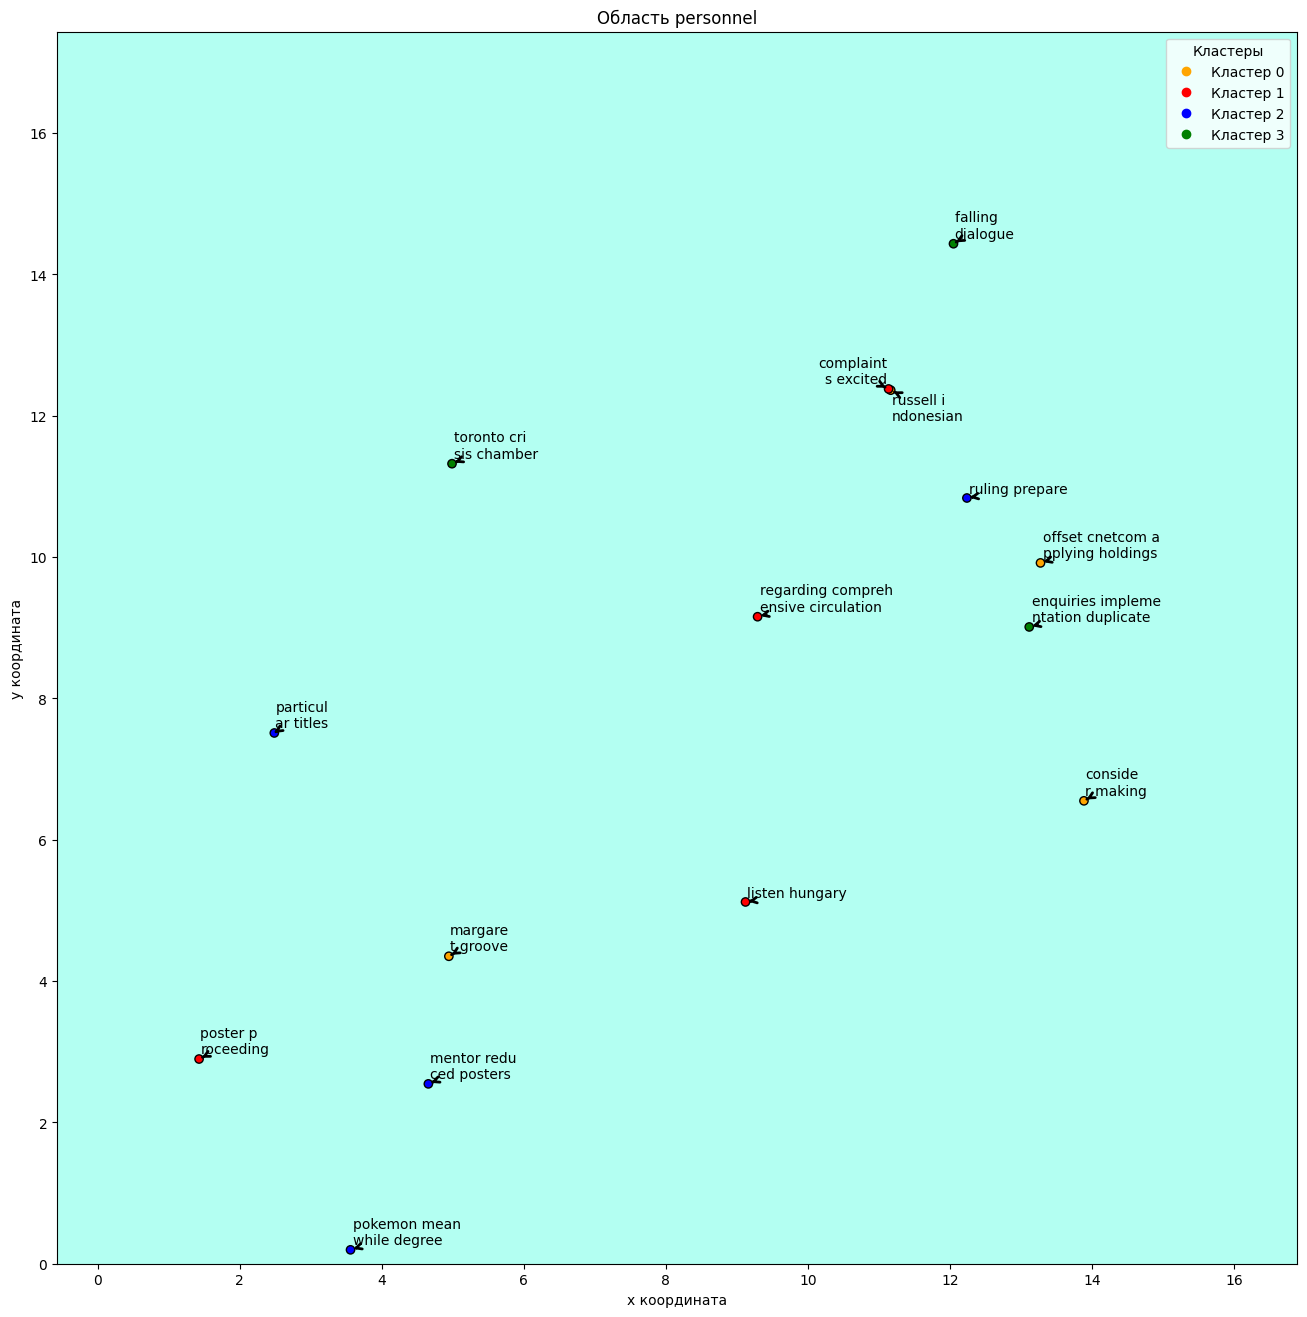

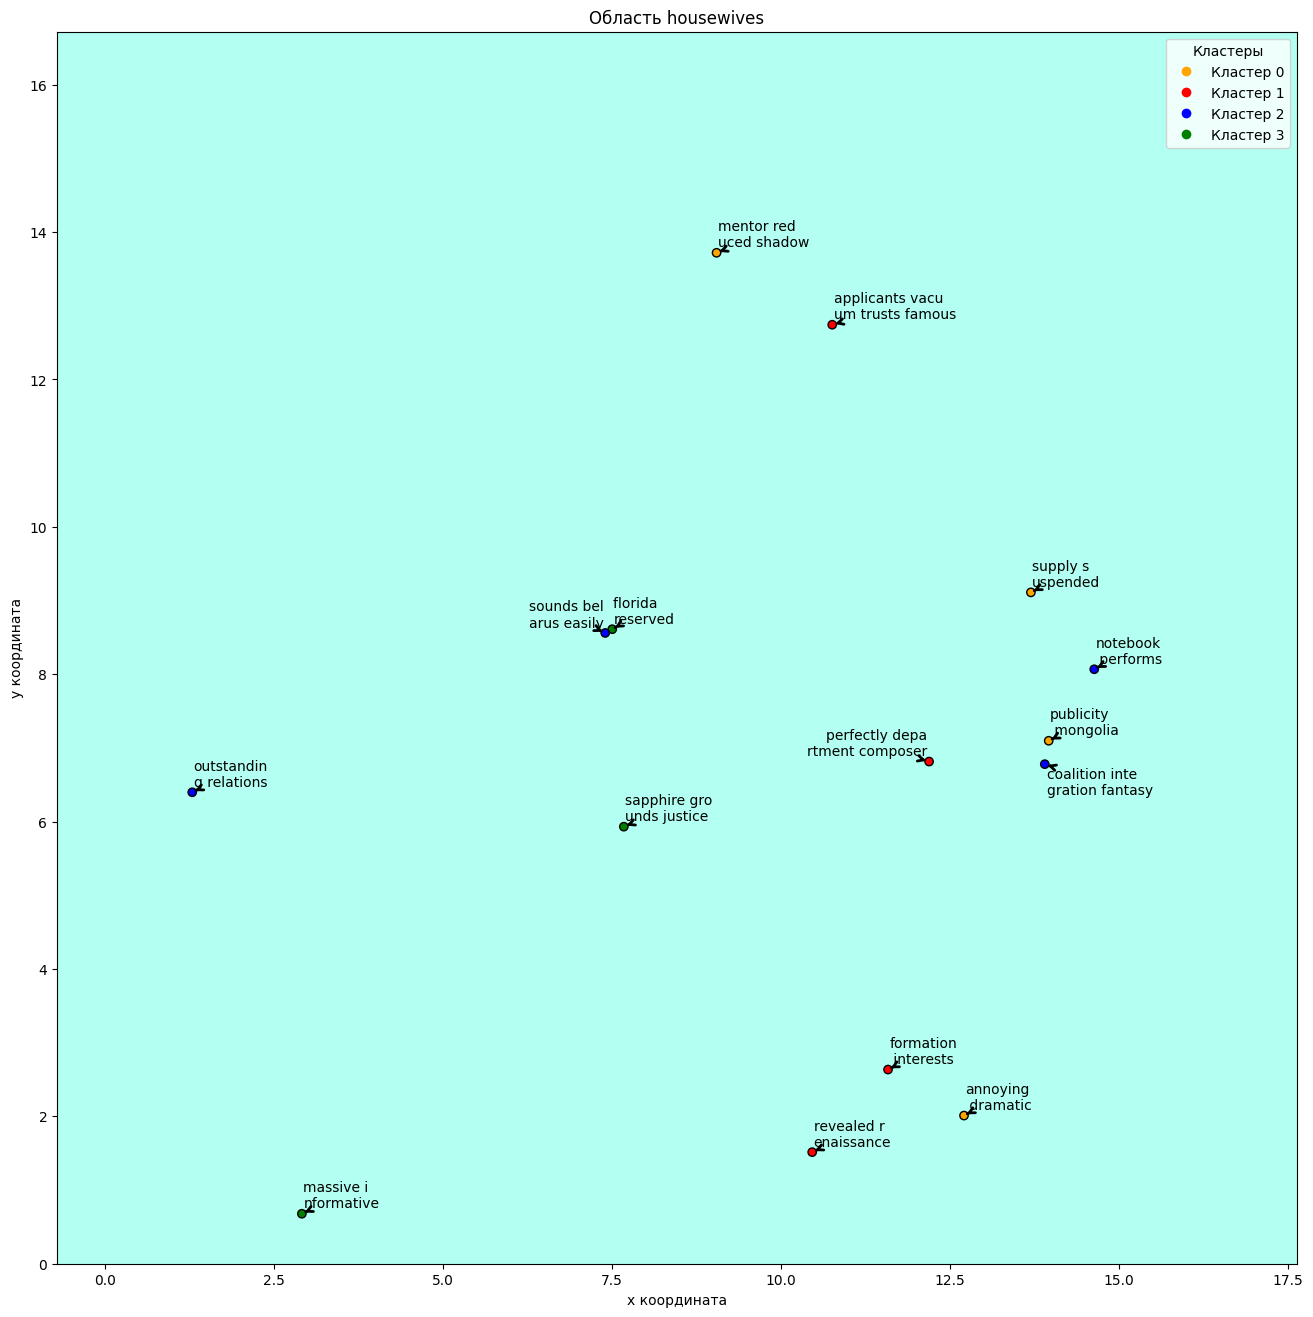

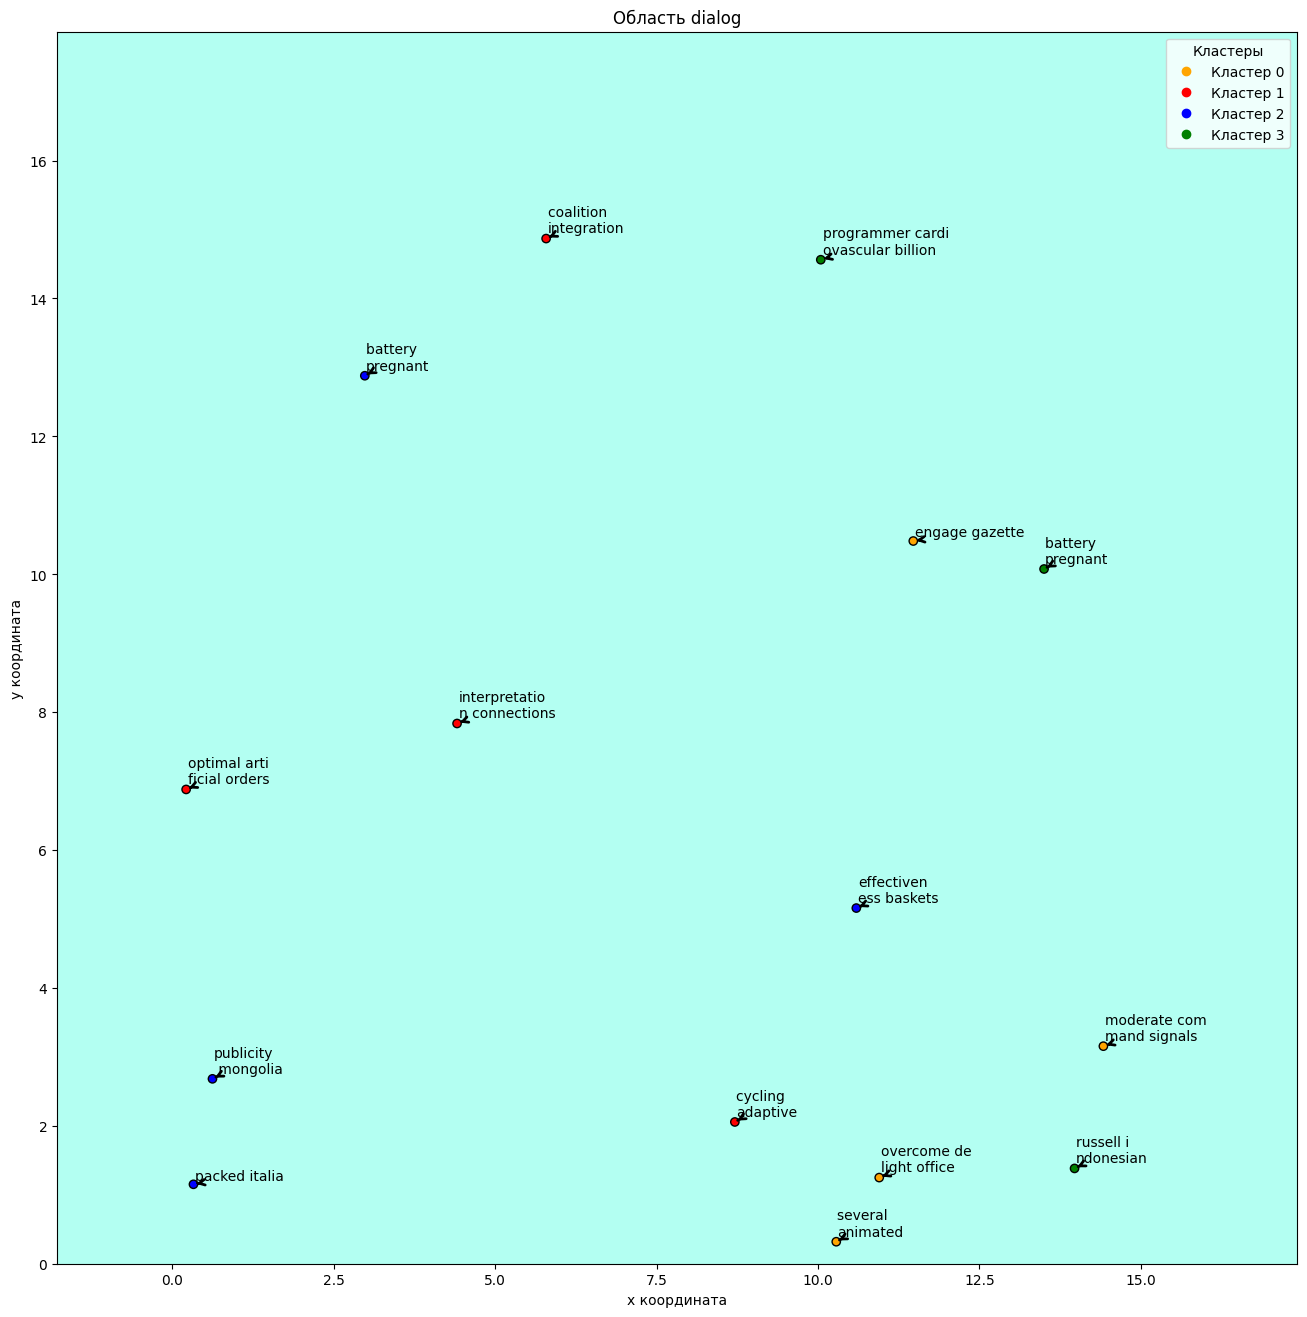

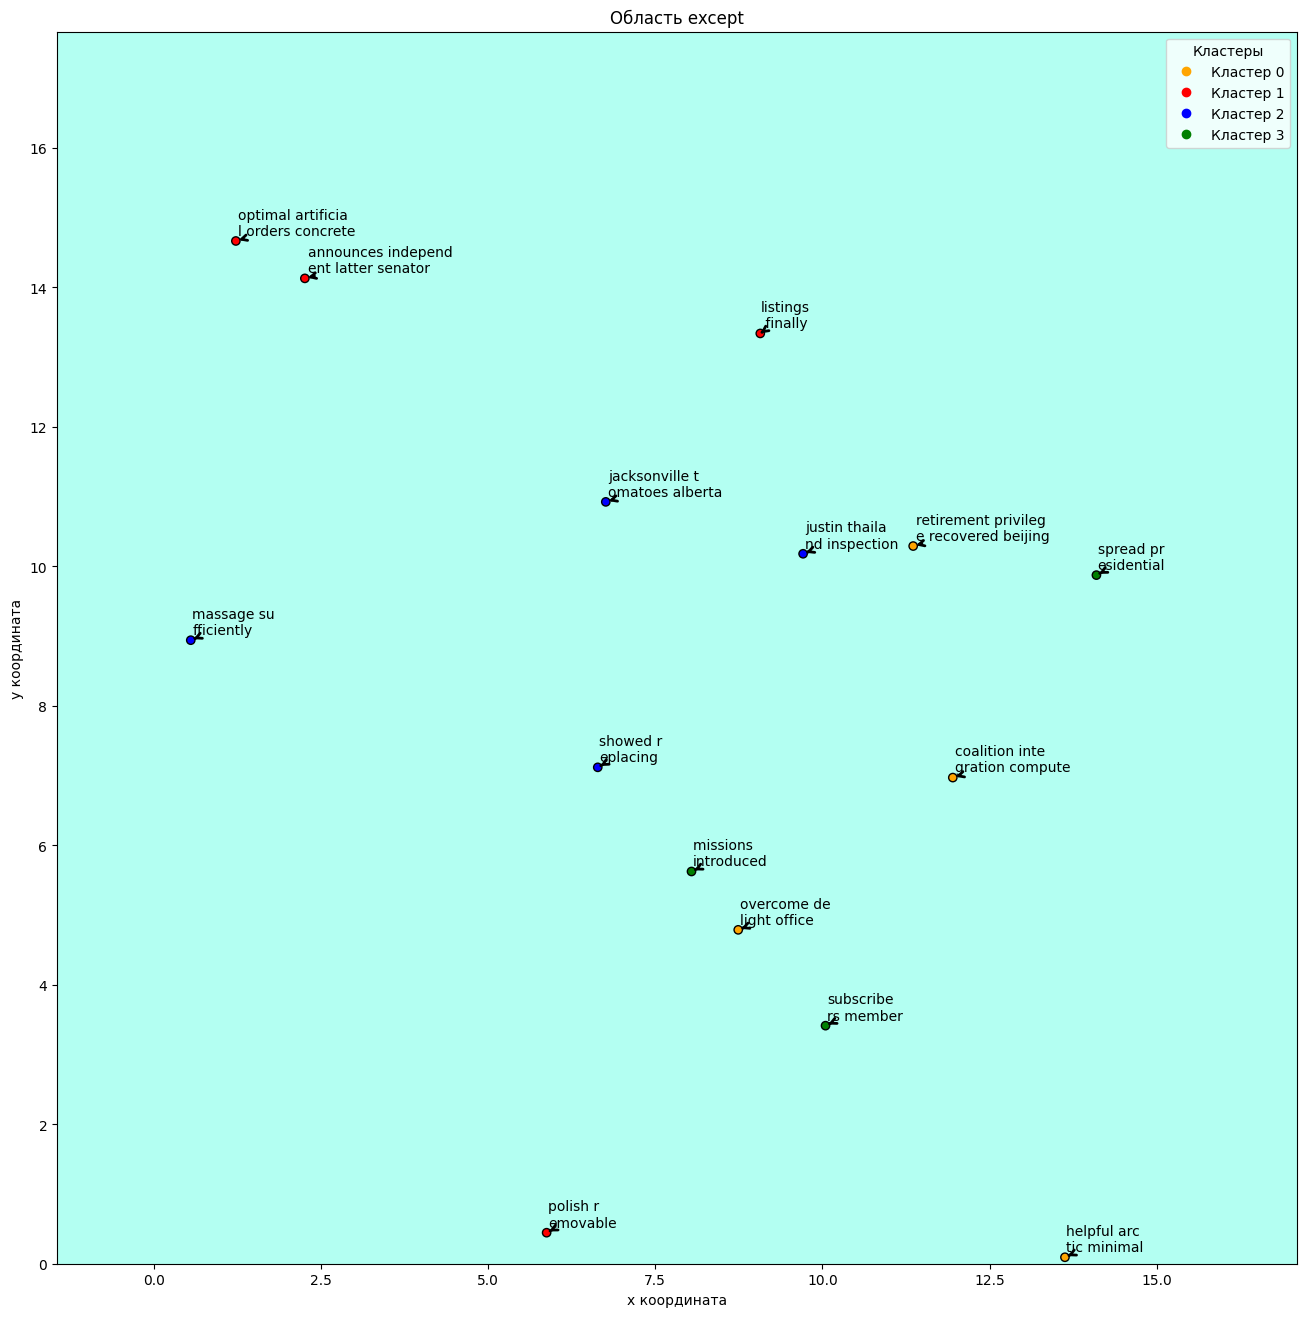

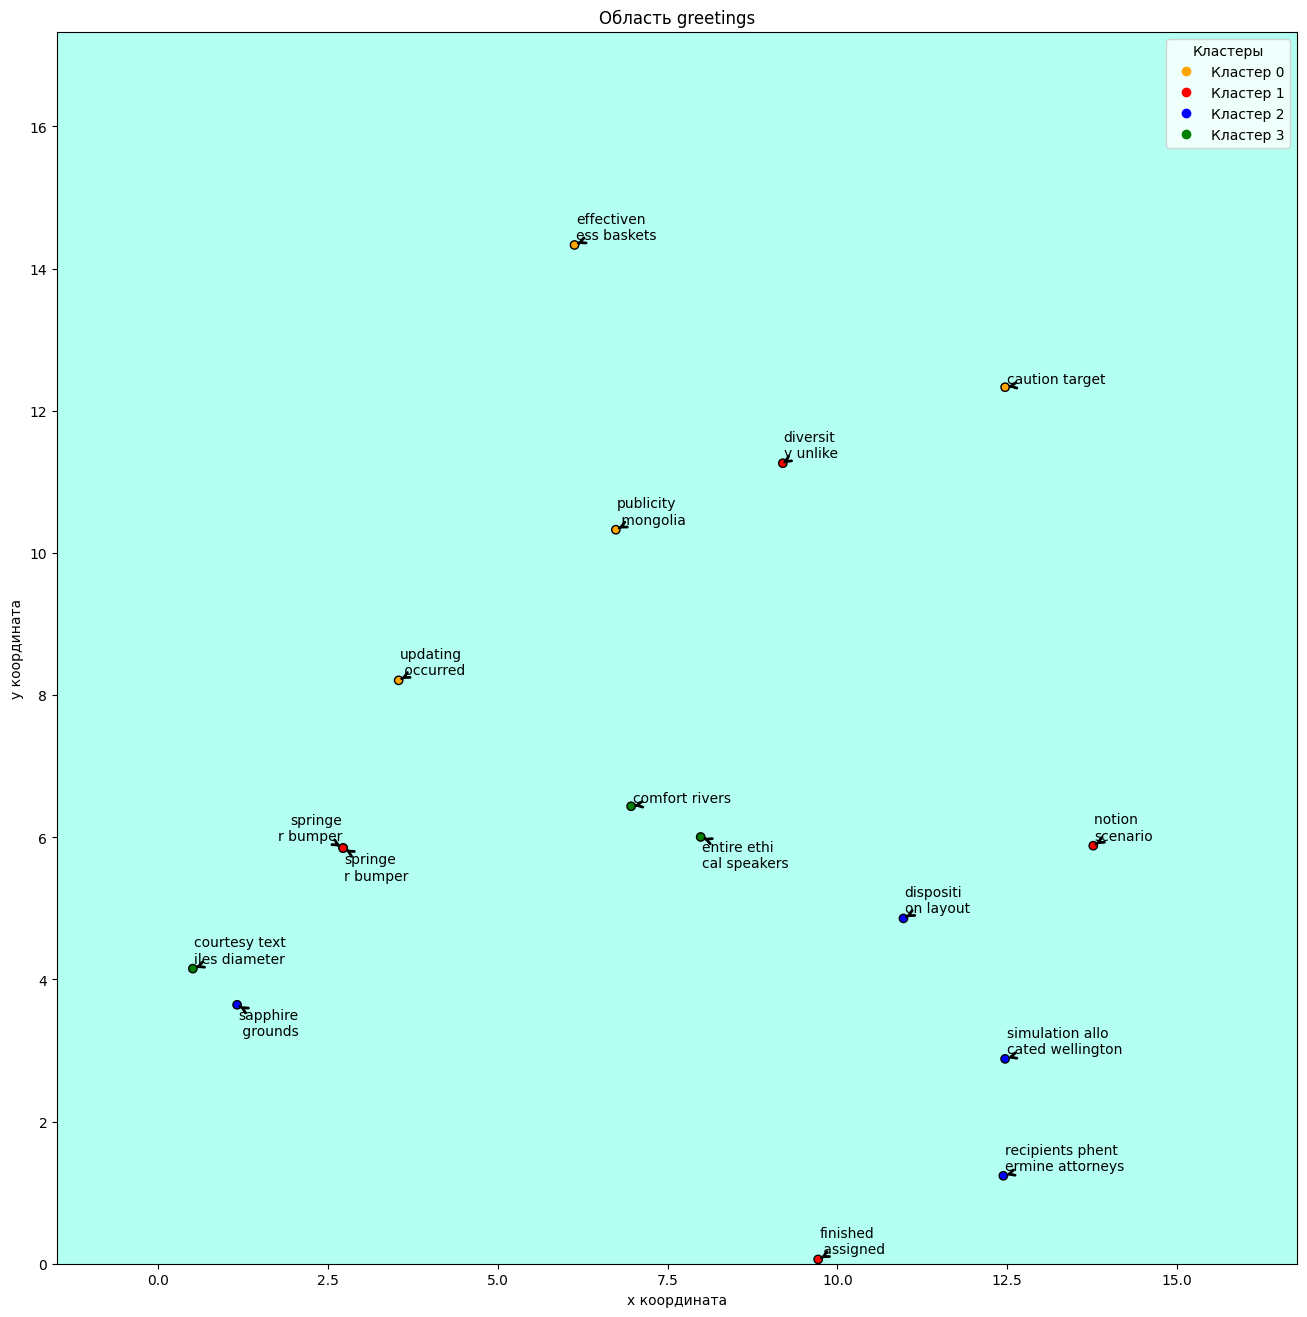

In [185]:
cols = ListedColormap(colors)
classes = cluster_unique.tolist()
for i in area_unique:
  text = []
  plt.figure(figsize = (16, 16))
  ax = plt.gca()
  ax.set_facecolor('#B3FFF2')
  subdata = data[data.area == i]
  plt.ylim((0, subdata.y.max()+3))
  plt.xlim((subdata.x.min()-2, subdata.x.max()+3))
  plt.title("Область " + i)
  plt.xlabel("x координата")
  plt.ylabel("y координата")
  z = plt.scatter(subdata.x, subdata.y, c = subdata.cluster, cmap = cols, edgecolors='black')
  plt.legend(title = "Кластеры", handles = z.legend_elements()[0], labels=classes, loc = 'best')
  for j in subdata.index:
    if len(subdata.keyword[j]) >= 15:
      subdata.keyword[j] = subdata.keyword[j][0:len(subdata.keyword[j])//2] + '\n' + subdata.keyword[j][len(subdata.keyword[j])//2:]
    text.append(plt.annotate(subdata.keyword[j], (subdata.x[j], subdata.y[j])))
  adjust_text(text, only_move={'points':'xy', 'texts':'xy'}, arrowprops=dict(arrowstyle="->", color='black', lw=2))
  plt.savefig(i+".png")
  plt.show()